# Named entity recognition

The exercise shows how we may extract elements such as names of companies, countries and similar objects from text.

## Tasks

1. Read the classification of [Named Entities](http://clarin-pl.eu/pliki/warsztaty/Wyklad3-inforex-liner2.pdf).
> Done
2. Read the [API of NER](http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki) in [Clarin](http://ws.clarin-pl.eu/ner.shtml).
> Done
3. Read the [documentation of CLL format](http://nlp.pwr.wroc.pl/redmine/projects/corpus2/wiki/CCL_format).
> Done
4. Sort bills according to their size and take top 50 (largest) bills.

In [29]:
import os
directory = '../ustawy/'
files = os.listdir(directory)
# print(files)
files.sort(key=lambda f: os.stat(directory+f).st_size, reverse = True)
# print(files[:50])
files50 = files[:50]

5. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive
   words starting with a capital letter (you will have to look at the inflected form of the word to check its
   capitalization) that do not occupy the first position in a sentence. E.g. the sentence:
   ```
   Wczoraj w Krakowie miało miejsce spotaknie prezydentów Polski i Stanów Zjednoczonych.
   ```
   should yield the following entries: `Kraków`, `Polska`, `Stan Zjednoczony`.

>$ docker run -it -p 9200:9200 apohllo/krnnt:0.1 python3 /home/krnnt/krnnt/krnnt_serve.py /home/krnnt/krnnt/data

In [17]:
import requests
import regex



def lemmatize(data):
    # data = "Wczoraj w Krakowie miało miejsce spotaknie prezydentów Polski i Stanów Zjednoczonych Ameryki Północnej. " \
    #        "Dzisiaj w Zwierzyńcu święto Rzeczpospolitej Polskiej".encode('utf-8')

    corp = []
    response = requests.post('http://localhost:9200', data=data)
    text = response.text

    reg = r"(\S*)\t\S*\n\t(\S*)"
    matches = regex.finditer(reg, text)

    for matchNum, match in enumerate(matches, start=1):
        word = match.group(1)
        lemm = match.group(2)
        combined = [lemm, word]
        corp.append(combined)

    return corp

import os

def lemmatize_corpus(directory, fileList):
    corp = []
    for filename in fileList:
        with open(os.path.join(directory + filename), 'r') as file:
            infile = file.read()
            corp_ = lemmatize(infile.encode('utf-8'))
            corp.extend(corp_)
            print('.', end='')
    return corp

# corp_lem = lemmatize_corpus(directory, files50)
# print(corp_lem)

In [18]:
# with open("corpus_lemmatized.py", 'w') as file:
#     file.write("list=")
#     file.write(corp_lem.__str__())

In [19]:
import corpus_lemmatized
corp_lem = corpus_lemmatized.list
# print(corp_lem)


In [20]:
def check_if_from_capital(corp_in):
    corp_out = []
    for data in corp_in:
        if data[1].istitle():
            corp_out.append(data[0].capitalize())
        else:
            corp_out.append(data[0])
    return corp_out

corp = check_if_from_capital(corp_lem)
# print(corp)

In [21]:
def find_capital_expression(corp):
    capitals = []
    was_title = False
    was_dot = True
    for t in corp:
        # print(t)
        if t == '.':
            was_dot = True
            continue
        if t.istitle():
            if was_dot:
                was_dot = False
                continue
            # print(t)
            if was_title:
                last =capitals.pop()
                if type(last)==list:
                    capitals.append(last + [t])
                else:
                    capitals.append([last, t])
            else:
                capitals.append(t)
                was_title = True
        else:
            was_title = False
    return capitals

capital_expressions = find_capital_expression(corp)
# print(capital_expressions)

6. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [22]:
def calculate_frequencies(capital_expressions):
    freqs = {}
    for cap in capital_expressions:
        # print(cap)
        c = ''.join(cap)
        if c not in freqs:
            freqs[c] = 1
        else:
            freqs[c] += 1
    freqs = dict(sorted(freqs.items(), key= lambda a: a[1], reverse=True))
    return freqs

freqs = calculate_frequencies(capital_expressions)

In [23]:
p_freqs = list(freqs)[:50]
for f in p_freqs:
    print(f)
# print(list(freqs)[:50])

Artykuł
Dziennik
RzeczpospolitaPolski
Policja
SkarbPaństwo
Minister
KasaChory
RadaMinister
StrażGraniczny
UniaEuropejski
PaństwowyStrażPożarny
Kodeks
Sprawiedliwość
Polski
PaństwowyKomisjaWyborczy
Rada
I
Zakład
ObronaNarodowy
MinisterSprawiedliwość
Fundusz
Finanse
Azot
Europejski
UrządPatentowy
PrezesUrząd
MinisterObronaNarodowy
Pozostały
UrządOchronaPaństwo
Tkanina
Państwo
Nawóz
Urząd
PrezesRadaMinister
Komendant
Przepis
Administracja
EuropejskiObszarGospodarczy
WolnyHandel
KomisjaWyborczy
Rozdział
EuropejskiPorozumienie
OpiekaSpołeczny
Biuro
Damski
Maszyna
InspektorNadzórWewnętrzny
SądWysoki
Chory
MinisterFinanse


7. Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the `n82` model.

In [24]:
user="michaljanpatyk@gmail.com"
lpmn='any2txt|wcrft2|liner2({"model":"n82"})'
import os
import time
url="http://ws.clarin-pl.eu/nlprest2/base"

def process(data):
    file_id = requests.post(f'{url}/upload/', data=data.encode('utf-8'),
                            headers={'Content-Type': 'binary/octet-stream'}).text
    task_id = requests.post(url=f'{url}/startTask/',
                            json={'lpmn': lpmn, 'file': file_id, 'user': user},
                            headers={'Content-Type': 'application/json'}).text

    status = requests.get(url=f'{url}/getStatus/{task_id}').json()
    while status['status'] in ('QUEUE', 'PROCESSING'):
        print('.', end='')
        time.sleep(0.5)
        try:
            status = requests.get(url=f'{url}/getStatus/{task_id}').json()
        except:
            status['status'] = 'PROCESSING'

    if status['status'] == 'DONE' and status['value']:
        processed_file_id = status['value'][0]['fileID']
        return requests.get(url=f'{url}/download{processed_file_id}').text

    elif status['status'] == 'ERROR':
        print('Error: ', status['value'])

def process_files(fileList, directory, out_directory):
    global_time = time.time()
    for filename in fileList:
        with open(os.path.join(directory + filename), 'r') as file:
            infile = file.read()
        result = process(infile)
        print('#')
        with open(os.path.join(out_directory, filename.split('.')[0]+'.ccl'), 'w') as out_file:
            out_file.write(result)
    print("GLOBAL %s seconds." % (time.time() - global_time))

ccl_directory = 'ccl/'
ccl_files = files = os.listdir(ccl_directory)

def check_what_was_proceded():
    files_to_proces = files50.copy()
    for filename in ccl_files:
        files_to_proces.remove(filename.split('.')[0]+'.txt')
    return files_to_proces

files_to_proces = check_what_was_proceded()
process_files(files_to_proces, directory, ccl_directory)

GLOBAL 1.430511474609375e-06 seconds.


In [25]:
# na podstawie opracowania znalezionego w sieci
def count_categories(directory):
    import xml.etree.ElementTree
    from itertools import groupby
    from collections import Counter
    categories = {}
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r') as file:
            file_xml = xml.etree.ElementTree.fromstring(file.read())
        for sentence in file_xml.iter(tag='sentence'):
            lexems = []
            for lexem in sentence.iter(tag='tok'):
                try:
                    base = lexem.find('lex/base').text
                except AttributeError:
                    base = lexem.find('orth').text

                interpretations = [(int(ann.text), ann.attrib['chan'], base)
                                   for ann in lexem.iter(tag='ann')
                                   if ann.text != '0']
                lexems.extend(interpretations)
            lexems.sort(key=lambda x: (x[0], x[1]))
            for (_, minor_cat), entity_lexems in groupby(lexems, key=lambda x: (x[0], x[1])):
                entity = ' '.join(lexem[2] for lexem in entity_lexems)
                major_cat = "_".join(minor_cat.split('_')[:2])

                minor_categories = categories.get(major_cat, {})
                minor_category_counter = minor_categories.get(minor_cat, Counter())
                minor_category_counter.update([entity])

                minor_categories[minor_cat] = minor_category_counter
                categories[major_cat] = minor_categories
    return categories

categories = count_categories(ccl_directory)
# print(categories)

8. Plot the frequency (histogram) of the coares-grained classes (e.g. nam_adj`, `nam_eve`, `nam_fac`).

nam_pro: 3191
nam_org: 9751
nam_fac: 147
nam_loc: 1537
nam_adj: 383
nam_eve: 30
nam_liv: 652
nam_oth: 557
nam_num: 14


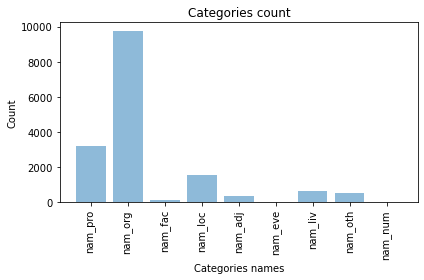

In [26]:
import matplotlib.pyplot as plt
def numbers():
    num = 0
    while True:
        yield num
        num += 1

def histogram(categories):
    ids = numbers()
    y_pos = []
    labels = []
    data = []
    for major_cat, minor_categories in categories.items():
            y_pos.append(next(ids))
            labels.append(major_cat)
            quantity = 0
            for minor_counts in minor_categories.values():
                quantity += sum(minor_counts.values())
            data.append(quantity)

    for label, val in zip(labels, data):
        print(f'{label}: {val}')

    plt.bar(y_pos, data, align='center', alpha=0.5)
    plt.xticks(y_pos, labels, rotation='vertical')
    plt.xlabel('Categories names')
    plt.ylabel('Count')
    plt.title('Categories count')
    plt.tight_layout()
    plt.show()

histogram(categories)

9. Display 10 most frequent Named Entities for each coarse-grained type.

In [27]:
from pprint import pprint
def top_10(categories):
    for major_cat, minor_categories in categories.items():
        top = []
        for minot_cat, minor_counts in minor_categories.items():
            top.extend(minor_counts.most_common(10))
        top.sort(key=lambda x: x[1], reverse=True)
        print(f'Top 10 for {major_cat}:')
        pprint(top[:10])
        print('\n')

top_10(categories)

Top 10 for nam_pro:
[('Dzieje_(Apostolskie) . u .', 1097),
 ('dziennik . u .', 438),
 ('dziennik . URz', 80),
 ('ordynacja podatkowy', 78),
 ('kodeks karny', 68),
 ('monitor Polska', 62),
 ('sprawa wewnętrzny', 51),
 ('kodeks postępowanie cywilny', 41),
 ('kodeks postępowanie administracyjny', 40),
 ('kodeks postępowanie karny', 36)]


Top 10 for nam_org:
[('skarb państwo', 410),
 ('minister sprawiedliwość', 322),
 ('unia europejski', 296),
 ('minister obrona narodowy', 287),
 ('rada minister', 279),
 ('państwowy komisja wyborczy', 267),
 ('prezes rad minister', 264),
 ('minister finanse', 234),
 ('państwowy straż pożarny', 225),
 ('prezes urząd', 201)]


Top 10 for nam_fac:
[('inspektor nadzór wewnętrzny', 50),
 ('komendant główny', 16),
 ('straż graniczny', 13),
 ('mangan', 8),
 ('obrona narodowy', 6),
 ('krajowy rejestr karny', 5),
 ('molibden', 4),
 ('zasłużony dawca przeszczep', 4),
 ('zatoka gdańska', 4),
 ('MN', 3)]


Top 10 for nam_loc:
[('rzeczpospolita polski', 812),
 ('Rzecz

10. Display 50 most frequent Named Entities including their count and fine-grained type.

In [28]:
def top_50(categories):
    top = []
    for minor_categories in categories.values():
        for minot_cat, minor_counts in minor_categories.items():
            top.extend([(content, minot_cat, count)
                        for content, count in minor_counts.most_common(50)])
    top.sort(key=lambda x: x[2], reverse=True)
    pprint(top[:50])

top_50(categories)

[('Dzieje_(Apostolskie) . u .', 'nam_pro_media_periodic', 1097),
 ('rzeczpospolita polski', 'nam_loc_gpe_country', 812),
 ('dziennik . u .', 'nam_pro_media_periodic', 438),
 ('skarb państwo', 'nam_org_institution', 410),
 ('złoty', 'nam_oth_currency', 334),
 ('minister sprawiedliwość', 'nam_org_institution', 322),
 ('unia europejski', 'nam_org_organization', 296),
 ('minister obrona narodowy', 'nam_org_institution', 287),
 ('rada minister', 'nam_org_institution', 279),
 ('państwowy komisja wyborczy', 'nam_org_institution', 267),
 ('prezes rad minister', 'nam_org_institution', 264),
 ('minister finanse', 'nam_org_institution', 234),
 ('państwowy straż pożarny', 'nam_org_organization', 225),
 ('polski', 'nam_adj_country', 204),
 ('prezes urząd', 'nam_org_institution', 201),
 ('urząd patentowy', 'nam_org_institution', 196),
 ('urząd ochrona państwo', 'nam_org_institution', 181),
 ('euro', 'nam_oth_currency', 118),
 ('sąd najwyższy', 'nam_org_institution', 116),
 ('EFTA', 'nam_org_organiza

11. Answer the following questions:

   i. Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with
      identification of the proper names?
   >Lepiej sprawdziła się metoda NER.
   >Potrafiła znaleźć znacznie więcej poprawnych nazw.

   ii. What are the drawbacks of the method based on capital letters?
   >Jeśli tekst będzie lowercaseowany (np.: w wyniku translacji maszynowej) nie uda nam się rozpoznać żadnych jednostek.

   iii. What are the drawbacks of the method based on NER?
   >Długi czas przetwarzania
   >Dużo błędnych przyporządkowań do grup.

   iv. Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this
      observation.
   >Najgorszy rezultat miała grupa Numex. Tylko dwie znalezione jednostki.
   >Living wypada kiepsko. Dużo znalezionych jednostek ale raczej niezgodnych z grupą.
   >Najlepszy rezultat, moim zdaniem, ma grupa Organization.
   >Wysoka skuteczność NER w tej grupie może wynikać z tego, że metoda Z Wielkiej Litery też dobrze rozpoznaje te jednostki.

   v. Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and
      "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej") ? If not, can you suggest an algorithm or a tool that
      would be able to group such names together?
   >NER nie jest wystarczający do rozpoznawania różnych wystąpień tego samego podmiotu.
   >Potrzebujemy narzędzia które połączy takie wystąpienia.
   >Być może dobrym rozwiązaniem byłoby wykorzystanie Osadzeń Słów.
   >Jeśli wektory dla NERów byłby podobne, można by domniemywać tożsamość znaczeń.

   vi. Can you think of a real world problem that would benefit the most from application of Named Entity Recognition
      algorithm?
   >Wydaje mi się, że tworzenie maszynowych streszczeń tekstów może być jedna z tych dziedzin które skorzystają najbardziej na rozpoznawaniu NERów.
   >Aby streścić tekst właściwie trzeba dobrze rozpoznać temat tekstu oraz relacje między podmiotami.


## Hints

1. Named entity recognition is a process aimed at the identification of entities mentioned in text by determining their
   scope and classifying them to a predefined type. The larger the number of types, the more difficult the problem is.
2. Named entities are usually proper names and temporal expressions. They usually convey the most important information
   in text.
3. IOB format is typically used to tag names entities. The name (IOB) comes from the types of tokens (_in_, _out_, _beginning_).
   The following example shows how the format works:
   ```
   W            O
   1776         B-TIME
   niemiecki    O
   zoolog       O
   Peter        B-PER
   Simon        I-PER
   Pallas       I-PER
   dokonał      O
   formalnego   O
   ...
   ```
4. The set of classes used in NER is partially task dependant. Some general classes such as names of people or cities
   are used universally, but categories such as references to law regulations is specific to legal information systems.